---
# QRT Data Challenge (2021) : Reconstruction of Liquid Asset Performance
**Author:** Mohamed MOHAMED EL BECHIR

---

This notebook presents my approach to the QRT Data Challenge (2021).
The objective is to predict the **sign** of liquid asset returns ($Y$) using concurrent illiquid asset returns ($X$).

More precisely, for each day $ t $, we observe:
- $ \mathbf{X}^t = (R_1^t, \dots, R_{100}^t) $: returns of 100 illiquid assets,
- $ \mathbf{Y}^t = (R'_1{}^t, \dots, R'_{100}{}^t) $: returns of 100 liquid assets.

Each one-day return is defined as:
$$
R_j^t = \frac{P_j^t}{P_j^{t-1}} - 1.
$$

The goal is to approximate an unknown mapping
$$
\eta : \mathbb{R}^{100} \to \mathbb{R}^{100},
\qquad
\mathbf{Y}^t \approx \eta(\mathbf{X}^t),
$$
using historical observations.

Performance is evaluated using a **Weighted Accuracy**:
$$
\text{Score} =
\frac{\sum |y_i| \cdot \mathbb{1}_{\text{sign}(\hat{y}_i) = \text{sign}(y_i)}}
{\sum |y_i|}
$$

This metric focuses on directional correctness while assigning higher importance to large-magnitude returns.


---
### $\color{#DAA520}{\textbf{Benchmark approach}}$

The official benchmark is intentionally simple and relies on a one-factor intuition.

For each liquid asset $ j $:
- compute historical correlations between $ R'_j $ and each illiquid return $ R_k $,
- select the illiquid asset $ k^\star $ with maximum absolute correlation,
- estimate a linear coefficient
$$
\hat{\beta}_{j,k^\star} = \frac{\operatorname{Cov}(R'_j, R_{k^\star})}{\operatorname{Var}(R_{k^\star})},
$$
using a shrinkage estimator of the covariance matrix,

- predict
$$
\hat{R}'_j{}^t = \hat{\beta}_{j,k^\star} \, R_{k^\star}^t,
\qquad
\hat{y}_j^t = \operatorname{sign}(\hat{R}'_j{}^t).
$$

This benchmark can be interpreted as projecting each liquid asset onto its **most informative illiquid factor**, trading bias for variance reduction.  
Despite its simplicity, it already captures a large fraction of the signal.

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Visual settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

---
# $\color{#DAA520}{\textbf{I. Data Analysis}}$ 
---
### $\color{#DAA520}{\textbf{Loading the data}}$ 



In [4]:
DATA_DIR = Path(".")

X_train = pd.read_csv(DATA_DIR / "X_train.csv")
Y_train = pd.read_csv(DATA_DIR / "y_train.csv")
supp_df = pd.read_csv(DATA_DIR / "supplementary_data" / "supplementary_data.csv")


first examine the structure of the training data.

Each row corresponds to a pair *(day, liquid target asset)*.
In particular:
- `ID_DAY` identifies the trading day (anonymized),
- `ID_TARGET` identifies the liquid asset whose return is predicted,
- `RET_1 ... RET_100` correspond to illiquid asset returns,
- `RET_TARGET` is the realized return of the liquid asset.

In [5]:
# merge inputs and targets
train_df = pd.merge(X_train, Y_train, on='ID')

# Identify Features
ret_cols = [c for c in train_df.columns if 'RET' in c and c != 'RET_TARGET']

print(f"Train dataset: {train_df.shape}")
print(f"Features:      {len(ret_cols)} illiquid assets")

train_df.head()


Train dataset: (267100, 104)
Features:      100 illiquid assets


,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET,RET_TARGET
0,0,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,139,-0.022351
1,1,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,129,-0.011892
2,2,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,136,-0.015285
3,3,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,161,-0.019226
4,4,3316,0.004024,0.009237,0.004967,NaN,0.01704,0.013885,0.041885,0.015207,...,0.01501,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,217,0.006644


### $\color{#DAA520}{\textbf{ Target Analysis}}$ 

My first step is to inspect the distribution of the liquid returns (`RET_TARGET`).

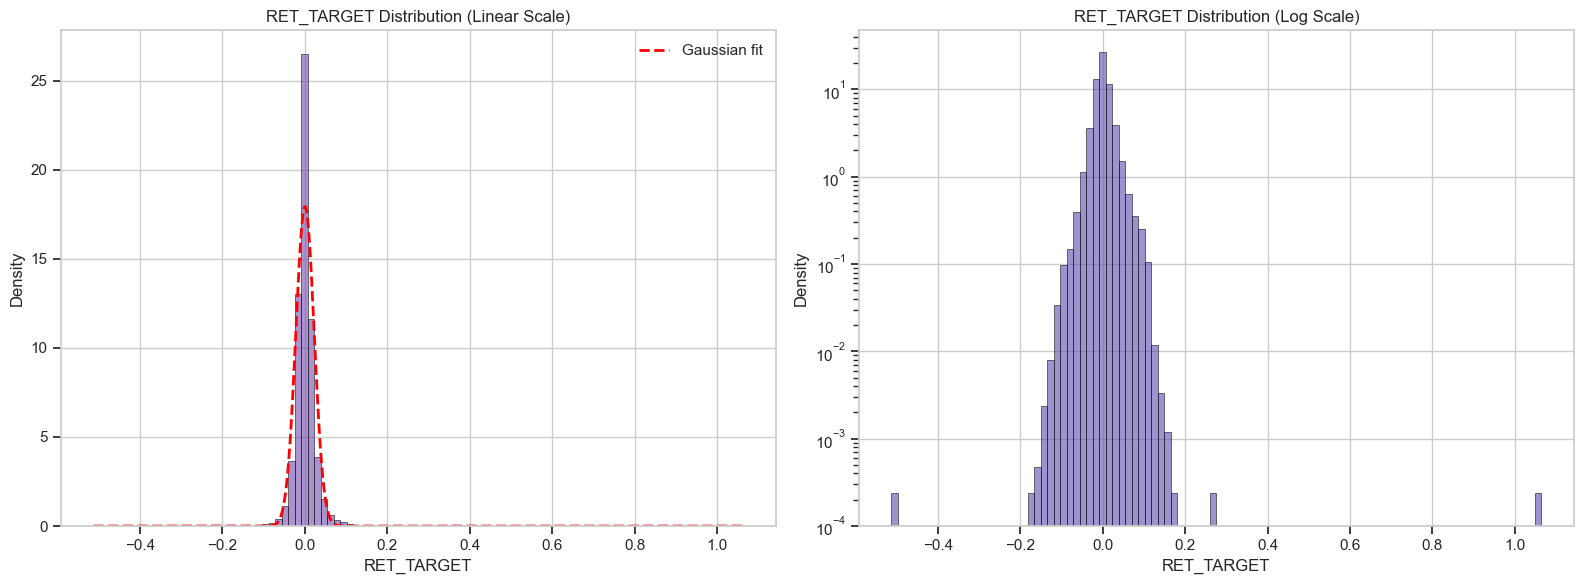

=== TARGET DISTRIBUTION STATS ===
Mean        : 3.9795e-04
Std         : 2.2215e-02
Kurtosis    : 25.03 (excess, Gaussian = 0)
Min Return  : -51.33%
Max Return  : 106.45%


In [6]:
def analyze_target_distribution(df):

    target = df["RET_TARGET"].dropna()

    # Moments
    mu   = target.mean()
    std  = target.std(ddof=0)
    kurt = target.kurtosis()  # excess kurtosis (Gaussian = 0)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Linear scale + Gaussian overlay 
    sns.histplot(
        target,
        bins=100,
        stat="density",
        alpha=0.6,
        color="#744CB0",
        ax=ax[0]
    )

    x = np.linspace(target.min(), target.max(), 500)
    pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / std) ** 2)
    ax[0].plot(x, pdf, "r--", lw=2, label="Gaussian fit")
    ax[0].set_title("RET_TARGET Distribution (Linear Scale)")
    ax[0].legend()

    # Log scale (for tail inspection) 
    sns.histplot(
        target,
        bins=100,
        stat="density",
        alpha=0.6,
        color="#5B4CB0",
        ax=ax[1]
    )
    ax[1].set_yscale("log")
    ax[1].set_ylim(bottom=1e-4)
    ax[1].set_title("RET_TARGET Distribution (Log Scale)")

    plt.tight_layout()
    plt.show()

    # STATS
    print("=== TARGET DISTRIBUTION STATS ===")
    print(f"Mean        : {mu:.4e}")
    print(f"Std         : {std:.4e}")
    print(f"Kurtosis    : {kurt:.2f} (excess, Gaussian = 0)")
    print(f"Min Return  : {target.min():.2%}")
    print(f"Max Return  : {target.max():.2%}")


analyze_target_distribution(train_df)

`RET_TARGET` is heavy-tailed (excess kurtosis ≈ 25): rare moves reach about −51% / +106% while std ≈ 2.2%.
 Under a squared-error loss, such extremes receive
a quadratic penalty and can dominate optimization.

To stabilize training, I apply target **clipping** during training, with a threshold
$\tau = 0.07$, (≈ 3× std), which affects only the extreme tails.

---

Next, I inspect the dependence structure between illiquid returns.

The benchmark relies on a single “best correlated” proxy. I check whether adding simple cross-sectional context (market / sector averages and relative returns) provides additional usable information for sign prediction.


Global Average Correlation (All 100 assets): 24.55%


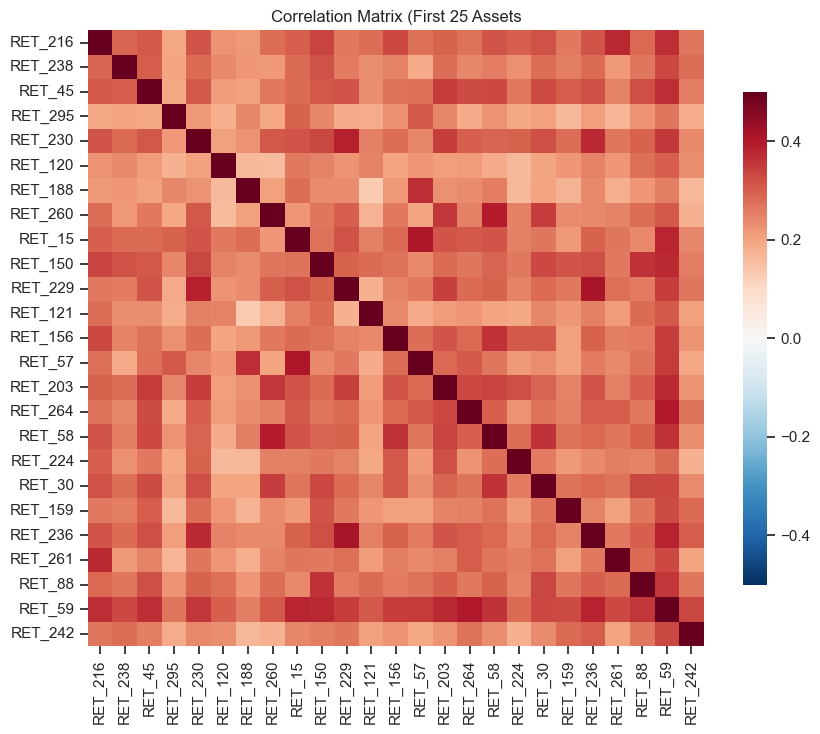

In [7]:
def plot_correlation_structure(df, subset_n=25):
    """
    Analyzes the correlation structure of the illiquid assets.
    - Calculates the global average correlation across ALL 100 features.
    - Plots a heatmap for a subset of features.
    """
    #  Compute correlation on the FULL asset universe (100 features)
    all_ret_cols = [c for c in df.columns if 'RET' in c and c != 'RET_TARGET']
    full_corr_matrix = df[all_ret_cols].corr()
    
    # Mask the diagonal (always 1.0) and lower triangle to avoid double counting
    mask_full = np.triu(np.ones_like(full_corr_matrix, dtype=bool), k=1)
    avg_corr_global = full_corr_matrix.where(mask_full).stack().mean()
    
    print(f"Global Average Correlation (All {len(all_ret_cols)} assets): {avg_corr_global:.2%}")
    
    # Visualization
    cols_viz = all_ret_cols[:subset_n]
    viz_corr_matrix = df[cols_viz].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(viz_corr_matrix, cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5, 
                square=True, cbar_kws={'shrink': 0.8})
    plt.title(f"Correlation Matrix (First {subset_n} Assets")
    plt.show()

plot_correlation_structure(train_df)

Average pairwise correlation is positive (24.55%), indicating broad cross-sectional co-movement.

Motivated by this structure, for each target asset I identify the peer return
with the highest absolute correlation on the training set, which serves as a
reference to characterize asset-specific co-movement patterns.

To assess when such correlation-based structures may be more or less informative,
I examine the cross-sectional dispersion of returns across assets for each observation.


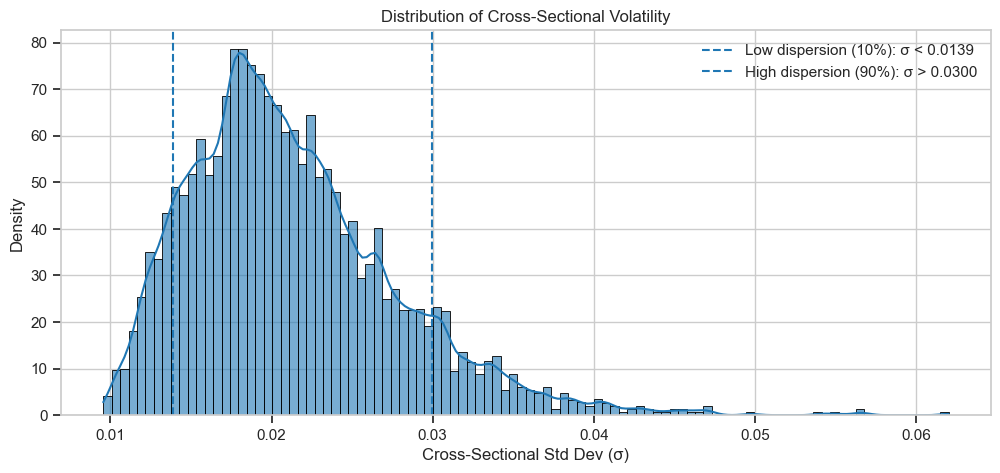

Mean volatility: 0.0213
Max volatility : 0.0620


In [8]:
def analyze_cross_sectional_volatility(df):
    """
    Analyzes the distribution of cross-sectional volatility
    across illiquid asset returns.
    """
    ret_cols = [c for c in df.columns if c.startswith('RET_') and c != 'RET_TARGET']
    mkt_vol = df[ret_cols].std(axis=1, ddof=0)

    plt.figure(figsize=(12, 5))
    sns.histplot(mkt_vol, bins=100, kde=True, stat="density", alpha=0.6)

    q_low = mkt_vol.quantile(0.10)
    q_high = mkt_vol.quantile(0.90)

    plt.axvline(q_low, linestyle='--', label=f'Low dispersion (10%): σ < {q_low:.4f}')
    plt.axvline(q_high, linestyle='--', label=f'High dispersion (90%): σ > {q_high:.4f}')

    plt.title("Distribution of Cross-Sectional Volatility")
    plt.xlabel("Cross-Sectional Std Dev (σ)")
    plt.legend()
    plt.show()

    print(f"Mean volatility: {mkt_vol.mean():.4f}")
    print(f"Max volatility : {mkt_vol.max():.4f}")

analyze_cross_sectional_volatility(train_df)

The distribution of cross-sectional volatility shows substantial variability
across observations,(mean ≈ 2.13%, tail up to ≈ 6.2%).

Low-dispersion observations correspond to more homogeneous asset behavior,
while high-dispersion observations reflect increased cross-sectional disagreement.

Given this variability, I will not rely on raw returns alone.

Instead, I express
returns relative to simple contextual averages computed across assets, and I add
cross-sectional volatility as an additional input feature.

I will also compute contextual averages at the sector level. Before doing so,
Let's inspect the `supplementary_data` to check sector sizes, since averages computed
over very small groups would be unstable.

--- Sector Viability Report ---
[Level 1] Groups with ≤ 2 assets: 0.0% (0/11)
[Level 2] Groups with ≤ 2 assets: 27.3% (6/22)
[Level 3] Groups with ≤ 2 assets: 51.1% (23/45)
[Level 4] Groups with ≤ 2 assets: 66.7% (44/66)


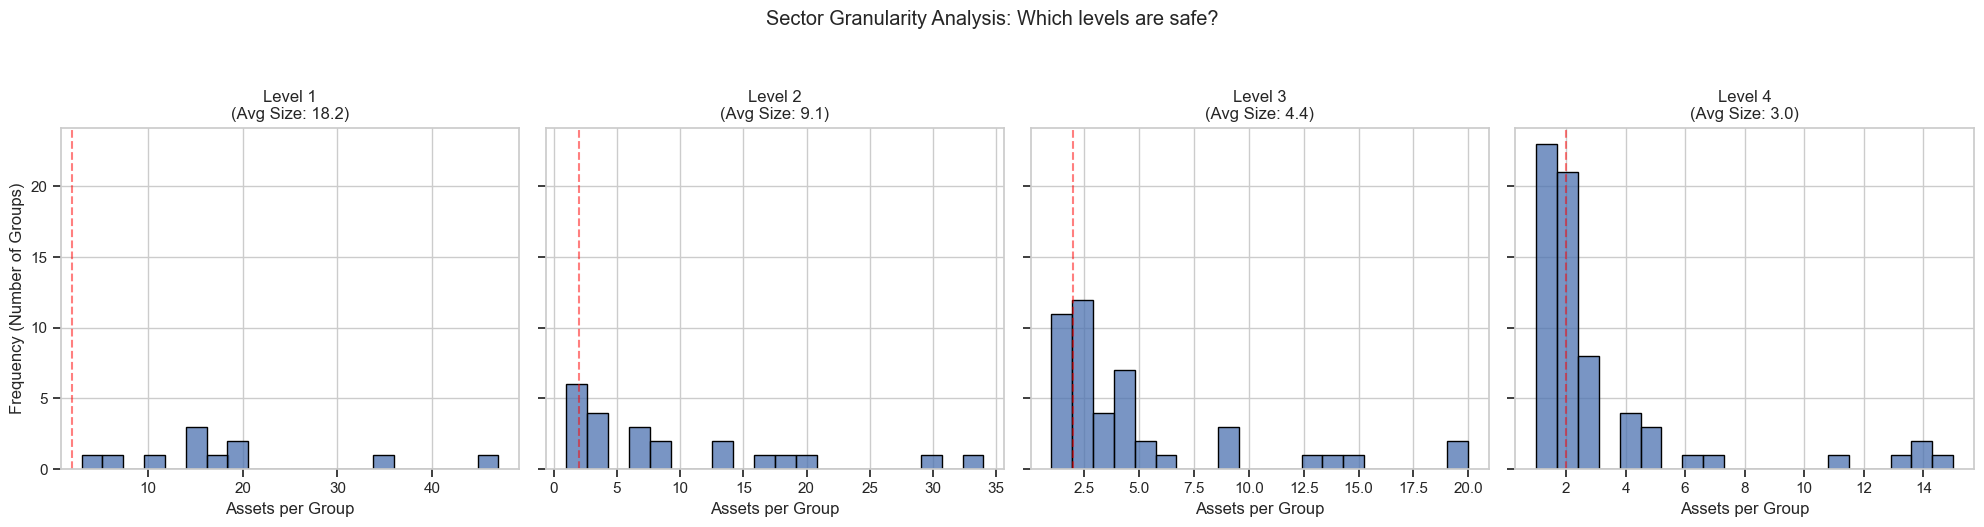

In [9]:
def analyze_sector_cardinality(supp_df):
    """
    Checks the distribution of group sizes for each classification level.
    
    Purpose:
    To assess whether sector-level averages can be computed reliably given
    the observed group sizes.

    """
    levels = [1, 2, 3, 4]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
    
    print("--- Sector Viability Report ---")
    
    for i, lvl in enumerate(levels):
        col = f"CLASS_LEVEL_{lvl}"
        
        # Count assets per unique sector group
        group_counts = supp_df[col].value_counts()
        
        # distribution
        sns.histplot(group_counts, bins=20, ax=axes[i], color='#4c72b0')
        axes[i].set_title(f"Level {lvl}\n(Avg Size: {group_counts.mean():.1f})")
        axes[i].set_xlabel("Assets per Group")
        
        # Groups with <= 2 assets
        n_tiny = (group_counts <= 2).sum()
        pct_tiny = n_tiny / len(group_counts)
        
        print(f"[Level {lvl}] Groups with ≤ 2 assets: {pct_tiny:.1%} ({n_tiny}/{len(group_counts)})")
        
        # Visual Threshold
        axes[i].axvline(2, color='red', linestyle='--', alpha=0.5)

    axes[0].set_ylabel("Frequency (Number of Groups)")
    plt.suptitle("Sector Granularity Analysis: Which levels are safe?", y=1.05)
    plt.tight_layout()
    plt.show()

analyze_sector_cardinality(supp_df)

At very fine classification levels, a large fraction of sector groups contain
only one or two assets. In such cases, sector-level averages are unstable and
often dominated by individual asset behavior.

Based on this observation, I primarily rely on coarser sector classifications
when constructing sector-level contextual averages.


---
# $\color{#DAA520}{\textbf{II. Feature Engineering Strategy}}$ 
---

## $\color{#DAA520}{\textbf{Core Idea}}$ 

The feature engineering strategy aims to provide the models with both global
context and relative information, without enforcing any explicit decomposition.

Rather than removing market effects, I construct features features that summarize how each asset behaves relative to simple contextual averages, leaving it to the
models to decide how this information should be used.

---
#### $\color{#DAA520}{\textbf{Target Clipping}}$

The target distribution exhibits heavy tails (excess kurtosis ≈ 25), meaning
that a small number of extreme returns can dominate the training process.
To limit this effect, target values are clipped during training:
$$
\tilde{y}_i = \mathrm{sign}(y_i)\,\min(|y_i|,\tau),
\quad \tau = 0.07.
$$


#### $\color{#DAA520}{\textbf{Handling Missing Data}}$

Missing values are handled using **median** imputation, an estimator that is less sensitive to asymmetry and extreme returns than the mean.


#### $\color{#DAA520}{\textbf{Market Volatility}}$

Since each row corresponds to a (day, target) pair, I treat each day $d$ as an
independent observation (since there is no temporal continuity).

For each day $d$, I compute the cross-sectional volatility of illiquid asset
returns:
$$
\sigma^{(d)} = \mathrm{std}\!\left(R_1^{(d)}, \dots, R_{100}^{(d)}\right).
$$

This feature summarizes how dispersed illiquid returns are on that day and is
included as an additional input to the model.



#### $\color{#DAA520}{\textbf{Relative Representations (Proxy-Excluded Context)}}$

For each target asset, I construct simple contextual averages by excluding the
selected proxy asset from the aggregation. The proxy is the illiquid asset with
the highest absolute correlation with the target on the training set.

This exclusion prevents the same illiquid return from contributing both as a
raw input feature and as part of the contextual average, which would otherwise
over-emphasize the proxy.

The market-level contextual average is therefore defined as:
$$
\mu^{(\mathrm{Mkt,\,excl})}
= \frac{1}{N-1} \sum_{j \neq k^\star} R_j,
$$
where $k^\star$ denotes the selected proxy asset.

Relative return representations are then constructed as:
$$
\tilde{R}_i = R_i - \mu^{(\mathrm{Mkt,\,excl})}.
$$

This representation provides the model with information about how each asset
behaves relative to the rest of the market on the same day.


---
When sector-level contextual averages are not well defined, they are omitted rather than forced.

I compute contextual averages by excluding the selected proxy asset from the
aggregation. This prevents the same illiquid return from contributing both as
a raw feature and as part of the contextual mean.

Formally, for a given observation, the market-level contextual mean is defined as:
$$
\mu^{(\text{Mkt, excl})} = \frac{1}{N-1} \sum_{j \neq k^\star} R_j,
$$
where $ k^\star $ denotes the selected proxy asset.



In [10]:
# Map assets to their Sector (Level 1) 
# Structure: {Asset_ID: Sector_ID}
sector_map = supp_df.set_index('ID_asset')['CLASS_LEVEL_1'].to_dict()

def get_contextual_features(sub_df, target_id, predictor_col):
    """
    Computes proxy-excluded contextual means (market & sector).
    The most correlated proxy asset is excluded to avoid double-counting
    the same signal in both raw and contextual features.
    """
    
    # Market contextual mean (proxy-excluded)
    all_features = [c for c in ret_cols if c != predictor_col]
    mkt_mean = sub_df[all_features].mean(axis=1)
    
    # Sector contextual mean (proxy-excluded)
    target_sector = sector_map.get(target_id)
    sec_mean = None
    
    if target_sector is not None:
        # Illiquid assets belonging to the same sector as the target
        sector_assets = [col for col in ret_cols 
                         if col.split('_')[1].isdigit() 
                         and sector_map.get(int(col.split('_')[1])) == target_sector
                         and col != predictor_col]

        
        if len(sector_assets) > 0:
            sec_mean = sub_df[sector_assets].mean(axis=1)
            
    return mkt_mean, sec_mean

# $\color{#DAA520}{\textbf{III. Model - Validation Strategy}}$

The modeling choices are guided by the need to balance simplicity and robustness
in a low signal-to-noise setting.

Rather than relying on a single hypothesis class, I combine multiple models with
different inductive biases into a single ensemble. This allows the final
prediction to aggregate linear and non-linear patterns while reducing sensitivity
to noise.

Specifically, I use a weighted ensemble of the following models:
$$
F(x) = \alpha_1 f_{\text{Ridge}}(x) +
       \alpha_2 f_{\text{XGB}}(x) +
       \alpha_3 f_{\text{ExtraTrees}}(x).
$$

- **Ridge Regression** provides a regularized linear baseline.
- **XGBoost** captures non-linear interactions between features.
- **ExtraTrees** reduces variance through randomized tree-based averaging.


The `ID_DAY` identifier is anonymized and does not represent a continuous time
index. Each day is treated as an independent observation, and no temporal
structure is assumed or exploited.

However, within a given day, asset returns exhibit non-negligible
cross-sectional dependence, as evidenced by the correlation analysis
in Section I. To avoid cross-sectional contamination across validation splits,
I use **GroupKFold** with grouping by `ID_DAY`.

This ensures that all observations from a given day are assigned exclusively to
either the training or the validation set, preventing the model from seeing
partial information from the same day during training and evaluation.


### $\color{#DAA520}{\textbf{Pipeline}}$ 


The pipeline is evaluated using a GroupKFold cross-validation scheme grouped by
`ID_DAY`, ensuring that all observations from a given day are kept together.

For each fold, models are trained independently for each target asset using
only observations corresponding to that asset, while sharing the same feature
space and model architecture.

The processing steps per fold are as follows:

1. **Global Feature Extraction**  
   Cross-sectional volatility (`RET_MKT_STD`) is computed once per day and added
   as a contextual feature.

2. **Proxy-Excluded Contextual Feature Construction**  
   For each target asset, the illiquid return with the highest training
   correlation is identified and excluded from the computation of
   contextual features. Market- and sector-level proxy-excluded averages
   are then constructed to control redundancy between raw and contextual
   inputs.

3. **Model Training**  
   Target values are clipped during training, and a weighted ensemble
   (Ridge, XGBoost, ExtraTrees) is fitted on the resulting feature set.

4. **Inference and Evaluation**  
   Predictions are generated for the validation set and evaluated using the
   weighted directional accuracy.





### $\color{#DAA520}{\textbf{Models}}$ 

In [ ]:
import os
N_JOBS = max(1, os.cpu_count() - 1)  # Use most CPU cores for parallel training,
                                     # but keep one core free to avoid system slowdown

def get_model():
    """
    Constructs a hybrid ensemble combining linear and tree-based models.
    The goal is to balance bias and variance in a low signal-to-noise setting.

    """
    
    # 1. Ridge: Linear Baseline
    m_ridge = make_pipeline(
    SimpleImputer(strategy="median"), # Robust imputation for missing values
    StandardScaler(),                 # Ensures comparable scale across assets
    Ridge(alpha=3.0)                  # Controls variance under multicollinearity
)
    
    # 2. Boosting Component: XGBoost
    # Shallow boosted trees to capture broad non-linear patterns

    m_xgb = XGBRegressor(            # XGBoost handles NaNs natively (learned default split direction).
                                     # Missingness is preserved as it may carry regime information.

            n_estimators=150,        # Many trees + low learning rate → smooth convergence
            max_depth=4,             # Shallow trees to limit model complexity and reduce overfitting
            learning_rate=0.04,      # Slow learning to reduce variance and improve stability
            subsample=0.8,           # Row subsampling (bagging effect) → decorrelates trees
            colsample_bytree=0.8,    # Feature subsampling → robustness under correlated assets
            reg_alpha=1.0,           # L1 regularization to discourage overly complex solutions
            reg_lambda=1.5,          # L2 regularization: smooths weights and stabilizes learning
            n_jobs=N_JOBS,
            random_state=42
        )

    
    # 3. Bagging Component: ExtraTrees
    # Randomized trees to reduce variance through ensemble averaging
    m_et = ExtraTreesRegressor(      # ExtraTrees supports NaNs natively in scikit-learn>=1.6.
                                     # I keep NaNs (median imputation degraded CV), to preserve potential missingness signal
                                     
            n_estimators=100,        # Ensemble averaging: reduces variance in a low-SNR regime
            max_depth=12,            # Controlled depth: allows non-linear interactions
                                     # without fitting asset-specific noise
            min_samples_leaf=15,     # Larger leaves to limit variance
            max_features=0.8,        # Feature subsampling: decorrelates trees and stabilizes predictions
            n_jobs=N_JOBS,
            random_state=42
            )
    
    # The weights are chosen heuristically to slightly favor non-linear models
    # while keeping a linear anchor for stability in a low signal-to-noise setting.
    # No dedicated weight tuning was performed.
    vote = VotingRegressor(
        estimators=[("ridge", m_ridge), ("xgb", m_xgb), ("et", m_et)],
        weights=[1, 2, 2] 
    )

    return vote


### $\color{#DAA520}{\textbf{Feature engineering helpers}}$ 

In [ ]:
# Evaluation metric
def weighted_accuracy(y_true, y_pred):
    """Official metric: magnitude-weighted directional accuracy."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    w = np.abs(y_true)
    denom = w.sum()
    if denom == 0:
        return 0.0

    # Handle zero returns by assigning a positive sign (convention)
    yt = np.sign(y_true); yt[yt == 0] = 1
    yp = np.sign(y_pred); yp[yp == 0] = 1

    return float((w * (yt == yp)).sum() / denom)


def best_correlated_ret_col_for_target(sub_df):
    """
    Returns the RET_* column with maximum absolute correlation to RET_TARGET
    computed on sub_df (training-only for that target).

    """
    if len(sub_df) < 10:
        return None

    X = sub_df[ret_cols]
    y = sub_df["RET_TARGET"]

    corrs = X.corrwith(y)
    counts = X.notna().mul(y.notna(), axis=0).sum()

    valid = counts >= 10
    if not valid.any():
        return None

    return corrs[valid].abs().idxmax()


In [35]:
# GLOBAL CONFIGURATION & FEATURE SPACE

CLIP_VAL = 0.07  
target_col = "RET_TARGET"
id_target_col = "ID_TARGET"
day_col = "ID_DAY"

# Global Feature Extraction: Market State (Volatility)
ret_cols = [c for c in train_df.columns 
            if c.startswith("RET_") 
            and c != target_col 
            and len(c.split('_')) > 1 
            and c.split('_')[1].isdigit()]

train_df['RET_MKT_STD'] = train_df[ret_cols].std(axis=1)

# column names
rel_mkt_cols = [f"{c}_REL_MKT" for c in ret_cols]
rel_sec_cols = [f"{c}_REL_SEC" for c in ret_cols]

# FEATURE SPACE (identical for all assets)
feat_cols = (
    ret_cols +                                   # raw illiquid asset returns
    ["RET_MKT_STD"] +                            # cross-sectional market dispersion
    ["RET_MKT_MEAN_EXCL_PROXY",                  # proxy-excluded market context
     "RET_SEC1_MEAN_EXCL"] +                     # proxy-excluded sector context
    rel_mkt_cols +                               # asset–market relative returns
    rel_sec_cols                                 # asset–sector relative returns
)

# Remove potential duplicates just in case
feat_cols = list(dict.fromkeys(feat_cols))

print(f"Feature Space: {len(feat_cols)} features per model.")

Feature Space: 303 features per model.


In [38]:
# VALIDATION LOOP
gkf = GroupKFold(n_splits=5)
t0 = time.perf_counter()
oof_preds = np.zeros(len(train_df)) # N'oublie pas d'initialiser ça !
fold_scores = []


for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups=train_df[day_col])):
    
    # Slice Data
    df_tr_global = train_df.iloc[train_idx]
    df_va_global = train_df.iloc[val_idx]
    
    # Group by Target Asset
    gb_tr = df_tr_global.groupby(id_target_col)
    gb_va = df_va_global.groupby(id_target_col)
    targets_in_val = df_va_global[id_target_col].unique()
    
    # Pre-calculate Best Proxy
    best_col_map = {}
    for tid in targets_in_val:
        if tid in gb_tr.groups:
             best_col_map[tid] = best_correlated_ret_col_for_target(gb_tr.get_group(tid))


    # Asset-Specific Training Loop
    for tid in tqdm(targets_in_val, desc=f"Fold {fold+1} | assets", leave=False):

        if tid not in gb_tr.groups: 
            continue

        # Instantiate a new model for this target asset and fold
        model = get_model()
        
        # Get Local Copies
        tr_sub = gb_tr.get_group(tid).copy()
        va_sub = gb_va.get_group(tid).copy()

        excl = best_col_map.get(tid)

        X_tr = tr_sub[ret_cols].to_numpy()
        X_va = va_sub[ret_cols].to_numpy()
        
        # Feature construction: contextual averages and relative returns
        if excl is not None:

            # 1. Compute Context 
            mkt_tr, sec_tr = get_contextual_features(tr_sub, tid, excl)
            mkt_va, sec_va = get_contextual_features(va_sub, tid, excl)
            
            # 2. Add Context as Features 
            tr_sub["RET_MKT_MEAN_EXCL_PROXY"] = mkt_tr
            va_sub["RET_MKT_MEAN_EXCL_PROXY"] = mkt_va

            # handle missing sector context
            if sec_tr is None:
                tr_sub["RET_SEC1_MEAN_EXCL"] = np.nan
                va_sub["RET_SEC1_MEAN_EXCL"] = np.nan
                tr_sub[rel_sec_cols] = np.nan
                va_sub[rel_sec_cols] = np.nan
            else:
                tr_sub["RET_SEC1_MEAN_EXCL"] = sec_tr
                va_sub["RET_SEC1_MEAN_EXCL"] = sec_va
                tr_sub[rel_sec_cols] = X_tr - sec_tr.values[:, None]
                va_sub[rel_sec_cols] = X_va - sec_va.values[:, None]
      
            # 3. Compute Difference (Asset - Trend)
            # Market Difference
            tr_sub[rel_mkt_cols] = X_tr - mkt_tr.values[:, None]
            va_sub[rel_mkt_cols] = X_va - mkt_va.values[:, None]
            
            # Sector Difference
            if sec_tr is not None:
                tr_sub[rel_sec_cols] = X_tr - sec_tr.values[:, None]
                va_sub[rel_sec_cols] = X_va - sec_va.values[:, None]

        # TRAINING
        y_loc_train = tr_sub[target_col].values
        y_loc_train_clipped = np.clip(y_loc_train, -CLIP_VAL, CLIP_VAL) # Clip targets

        
        model.fit(tr_sub[feat_cols], y_loc_train_clipped)
        # Inference
        oof_preds[va_sub.index] = model.predict(va_sub[feat_cols])
        
    # Fold score
    fold_y_true = train_df.iloc[val_idx][target_col]
    fold_y_pred = oof_preds[val_idx]
    score = weighted_accuracy(fold_y_true, fold_y_pred)
    fold_scores.append(score)
    print(f"Fold {fold+1} Weighted Accuracy: {score:.4%}")

    del df_tr_global, df_va_global, gb_tr, gb_va
    gc.collect()


total_time = time.perf_counter() - t0
print("\n" + "="*40)
print(f"FINAL CV SCORE: {np.mean(fold_scores):.4%} "
      f"(Std: {np.std(fold_scores):.4%})")
print(f"TOTAL RUN TIME: {total_time/60:.2f} min")
print("="*40)

Fold 1 Weighted Accuracy: 75.5322%


Fold 2 Weighted Accuracy: 73.5784%


Fold 3 Weighted Accuracy: 74.9465%


Fold 4 Weighted Accuracy: 74.9771%


Fold 5 Weighted Accuracy: 74.9019%

FINAL CV SCORE: 74.7872% (Std: 0.6467%)
TOTAL RUN TIME: 7.74 min


The cross-validation results show consistent performance across folds:

- **Mean Weighted Accuracy:** **74.78%**
- **Standard Deviation:** **0.64%**

The limited dispersion of scores across folds indicates that the performance
is not driven by a single favorable train–validation split and remains stable
under different partitions of the data defined by `ID_DAY`.

---

Before generating the final submission, I inspect feature importance measures
from a single model trained for one asset during cross-validation. This analysis
is intended as a qualitative illustration of how the constructed features are
used by the tree-based estimators.


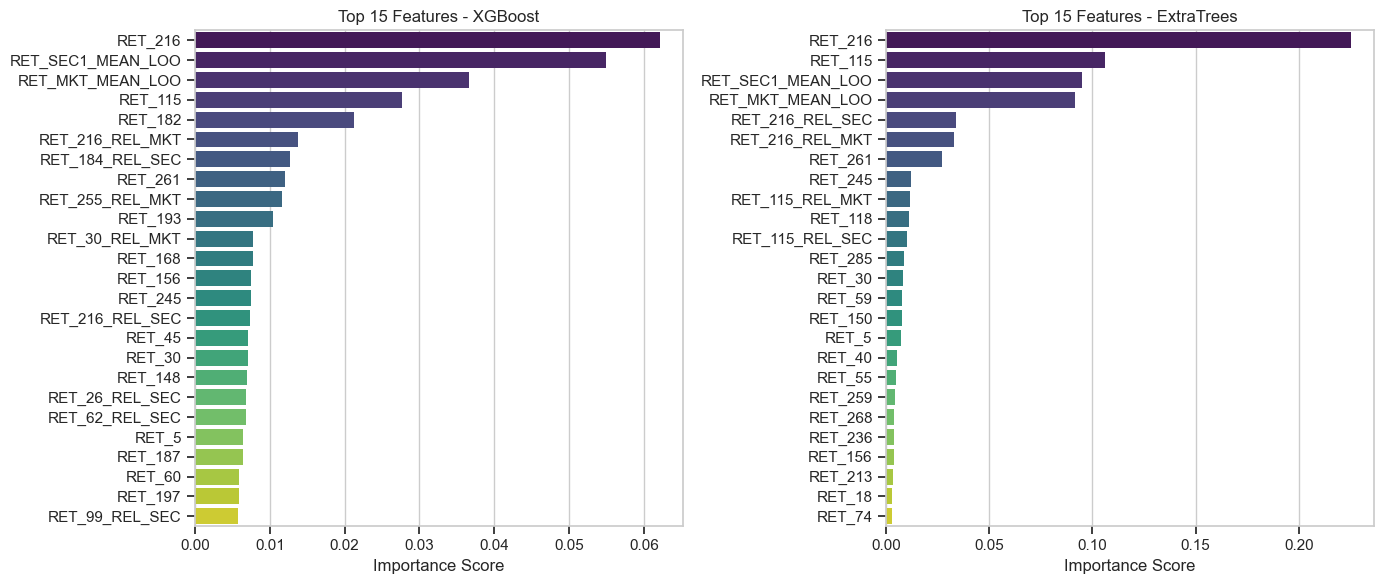

In [ ]:
# Model Interpretability: Feature Importance 
# We extract feature importances from the tree-based estimators in the VotingRegressor
# Index 1 = XGBoost 
# Index 2 = ExtraTrees

estimators_info = [
    (model.estimators_[1], "XGBoost"),
    (model.estimators_[2], "ExtraTrees")
]

plt.figure(figsize=(14, 6))

for i, (estimator, name) in enumerate(estimators_info):
    if hasattr(estimator, 'feature_importances_'):
        # Create a dataframe for visualization
        fi_df = pd.DataFrame({
            'Feature': feat_cols, 
            'Importance': estimator.feature_importances_
        })
        
        # Sort and take Top 25
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(25)
        
        plt.subplot(1, 2, i+1)
        sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
        plt.title(f'Top 25 Features - {name}')
        plt.xlabel('Importance Score')
        plt.ylabel('')

plt.tight_layout()
plt.show()

The feature importance plots provide insight into how the tree-based models
utilize the constructed feature space.

Both XGBoost and ExtraTrees assign non-negligible importance to a mix of raw
illiquid returns and contextual features, including market- and sector-level
averages as well as relative return representations.

Importance scores decay rapidly beyond a small subset of features, suggesting
that, for this particular target asset, predictive information concentrates on
a limited number of inputs.

While the two models do not rank individual features identically, they emphasize
similar feature families. This observation is consistent with using an ensemble as a simple variance-reduction heuristic rather than relying on a single estimator.

---

### $\color{#DAA520}{\textbf{Threshold Calibration on Out-of-Fold Predictions}}$ 

The evaluation metric depends only on the sign of predictions. As a result,
a small global bias in predicted values can materially impact performance.

Instead of enforcing a fixed zero threshold, I calibrate a ***post-hoc decision
threshold*** using ***out-of-fold (OOF)*** predictions only. This step affects the
decision rule but not model training, and preserves a strict separation between
training and evaluation data.

Because the raw OOF score curve is noisy, the threshold is selected by scanning
a fine grid, smoothing the resulting scores, and choosing the maximum of the
smoothed curve. This favors a stable performance region over a noise-driven
local optimum.

This calibration adjusts only the decision boundary and does not introduce
information leakage.


Raw optimum threshold   : -0.000102
Robust optimum threshold: -0.000078


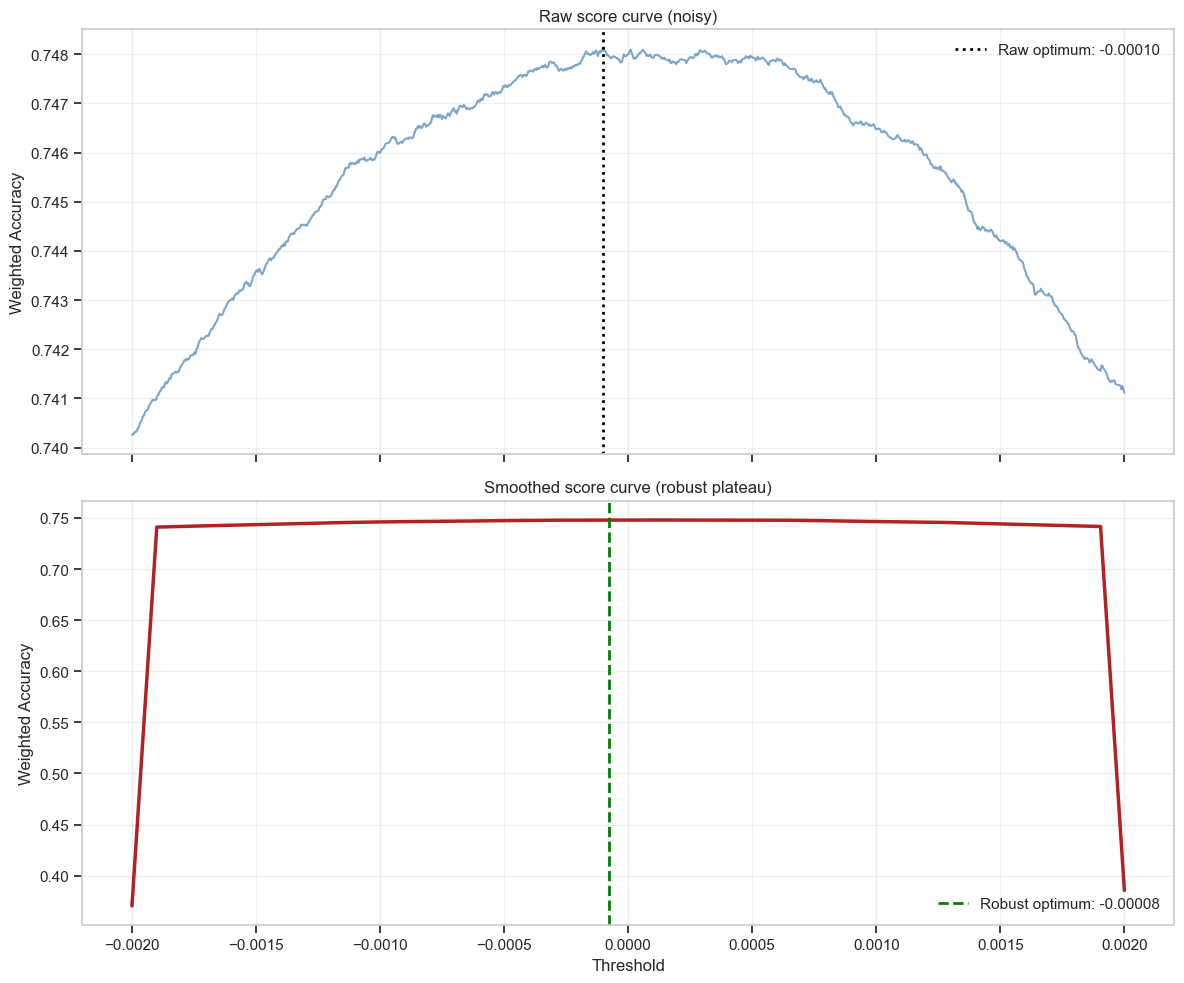

In [ ]:
def calibrate_threshold(y_true, y_pred, metric_fn, threshold_range=(-0.002, 0.002), n_grid=1000, smooth_window=50,):
    """
    Robust post-hoc threshold calibration using OOF predictions.

    Returns:
        thresholds        : grid of tested thresholds
        scores_raw        : raw metric values
        scores_smoothed   : smoothed metric values
        best_th_raw       : threshold maximizing raw score
        best_th_safe      : threshold maximizing smoothed score
    """

    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_grid)

    scores_raw = np.array([
        metric_fn(y_true, y_pred - th) for th in thresholds
    ])

    kernel = np.ones(smooth_window) / smooth_window
    scores_smoothed = np.convolve(scores_raw, kernel, mode="same")

    best_th_raw = thresholds[np.argmax(scores_raw)]
    best_th_safe = thresholds[np.argmax(scores_smoothed)]

    return thresholds, scores_raw, scores_smoothed, best_th_raw, best_th_safe


# Run calibration on OOF predictions 
y_true_all = train_df[target_col].values

(
    thresholds,
    scores_raw,
    scores_smoothed,
    best_th_raw,
    best_th_safe,
) = calibrate_threshold(
    y_true=y_true_all,
    y_pred=oof_preds,
    metric_fn=weighted_accuracy,
)

print(f"Raw optimum threshold   : {best_th_raw:.6f}")
print(f"Robust optimum threshold: {best_th_safe:.6f}")


# === Visualization ===
fig, (ax_raw, ax_smooth) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Raw (noisy) curve
ax_raw.plot(thresholds, scores_raw, color="steelblue", alpha=0.7)
ax_raw.axvline(best_th_raw, color="black", linestyle=":", linewidth=2,
               label=f"Raw optimum: {best_th_raw:.5f}")
ax_raw.set_title("Raw score curve (noisy)")
ax_raw.set_ylabel("Weighted Accuracy")
ax_raw.grid(alpha=0.3)
ax_raw.legend()

# Smoothed curve
ax_smooth.plot(thresholds, scores_smoothed, color="firebrick", linewidth=2.5)
ax_smooth.axvline(best_th_safe, color="green", linestyle="--", linewidth=2,
                  label=f"Robust optimum: {best_th_safe:.5f}")
ax_smooth.set_title("Smoothed score curve")
ax_smooth.set_xlabel("Threshold")
ax_smooth.set_ylabel("Weighted Accuracy")
ax_smooth.grid(alpha=0.3)
ax_smooth.legend()

plt.tight_layout()
plt.show()


# $\color{#DAA520}{\textbf{IV. Final Training - Submission}}$


In [43]:
FINAL_THRESHOLD = -0.000078 # from OOF calibration

X_test = pd.read_csv("X_test.csv")

# Global contextual feature: cross-sectional volatility
X_test["RET_MKT_STD"] = X_test[ret_cols].std(axis=1)

# Group training and test data by target asset
gb_train = train_df.groupby(id_target_col)
gb_test  = X_test.groupby(id_target_col)

all_targets = X_test[id_target_col].unique()
test_preds = np.zeros(len(X_test))


# Identify, for each target asset, the most correlated illiquid return
best_col_map = {}
for tid in all_targets:
    if tid in gb_train.groups:
        best_col_map[tid] = best_correlated_ret_col_for_target(
            gb_train.get_group(tid)
        )

for tid in tqdm(all_targets, desc="Final inference | assets"):

    if tid not in gb_train.groups:
        continue

    model = get_model()

    tr_sub = gb_train.get_group(tid).copy()
    te_sub = gb_test.get_group(tid).copy()
    excl = best_col_map.get(tid)

    if excl is not None:
        # Contextual averages (Leave-One-Out)
        mkt_tr, sec_tr = get_contextual_features(tr_sub, tid, excl)
        mkt_te, sec_te = get_contextual_features(te_sub, tid, excl)

        tr_sub["RET_MKT_MEAN_EXCL_PROXY"] = mkt_tr
        te_sub["RET_MKT_MEAN_EXCL_PROXY"] = mkt_te

        # Sector-level contextual features 
        if sec_tr is None:
            tr_sub["RET_SEC1_MEAN_EXCL"] = np.nan
            te_sub["RET_SEC1_MEAN_EXCL"] = np.nan
            tr_sub[rel_sec_cols] = np.nan
            te_sub[rel_sec_cols] = np.nan
        else:
            tr_sub["RET_SEC1_MEAN_EXCL"] = sec_tr
            te_sub["RET_SEC1_MEAN_EXCL"] = sec_te
            tr_sub[rel_sec_cols] = tr_sub[ret_cols].values - sec_tr.values[:, None]
            te_sub[rel_sec_cols] = te_sub[ret_cols].values - sec_te.values[:, None]

        # Market-relative return features
        tr_sub[rel_mkt_cols] = tr_sub[ret_cols].values - mkt_tr.values[:, None]
        te_sub[rel_mkt_cols] = te_sub[ret_cols].values - mkt_te.values[:, None]

    # Train a final model for this target asset on the full training history
    y_train = np.clip(tr_sub[target_col].values, -CLIP_VAL, CLIP_VAL)
    model.fit(tr_sub[feat_cols], y_train)

    # Generate predictions for the test set
    test_preds[te_sub.index] = model.predict(te_sub[feat_cols])

    del tr_sub, te_sub
    gc.collect()

# Submission
submission = X_test[["ID"]].copy()
# Apply robust threshold BEFORE taking the sign
submission["RET_TARGET"] = np.sign(test_preds - FINAL_THRESHOLD)
submission["RET_TARGET"] = submission["RET_TARGET"].replace(0, 1).astype(int)
submission.to_csv("submission.csv", index=False)

submission.head()


Final inference | assets: 100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


,ID,RET_TARGET
0,267100,1
1,267101,-1
2,267102,-1
3,267103,1
4,267104,1


# $\color{#DAA520}{\textbf{Conclusion}}$
---

This solution achieved a **Top 3 ranking** on the public leaderboard, improving
from an initial Top 4% position after introducing a post-hoc calibration of the
decision threshold. The final public score is consistent with the local
GroupKFold cross-validation performance, indicating a limited gap between
validation and leaderboard evaluation within the challenge setting.

The main focus of this work was not to increase model complexity, but to build a
feature representation that remains stable in a low signal-to-noise,
cross-asset environment. The final model combines raw illiquid returns with
simple contextual and relative features computed across assets, and relies on a
moderate ensemble rather than a single estimator.

From a modeling perspective, two observations stood out. First, tree-based
models consistently make use of both absolute returns and relative
representations, indicating that contextual information is helpful alongside
raw inputs. Second, predictive contributions tend to concentrate on a limited
subset of features for a given target asset, rather than being spread uniformly
across the cross-section.

Several alternative approaches were explored during development. In particular,
neural networks (MLP) were found to be unstable in this tabular, low-SNR setting,
and PCA-based preprocessing tended to remove information useful for
asset-specific prediction. For these reasons, they were not retained in the
final solution.

With more time and computational resources, possible extensions would include
testing non-linear dimensionality reduction methods or more systematic tuning
of ensemble weights under cross-validation.

---

If you have any questions or comments about this work, I would be happy to
discuss them at:  
**mohamed.mohamedelbechir@telecom-paris.fr**
